# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
%tensorflow_version  2.x
import tensorflow as tf
import numpy as np
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

In [18]:
from google.colab import drive
drive.mount('/content/drive')


import tensorflow as tf
import csv
import numpy as np
from PIL import Image
import pandas as pd

from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon

import matplotlib.pyplot as plt
import matplotlib.patches as patches

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change directory

In [0]:
DATASET_FOLDER = '/content/drive/My Drive/Residency9/'


### Load the training data from train.csv file

In [0]:
TRAIN_CSV_ORIG = DATASET_FOLDER+"train_labels.csv"


In [0]:
images_path = DATASET_FOLDER + "images_racoon/images_racoon.rar"
OUTPUT_DIR = DATASET_FOLDER + "images_racoon/"


In [0]:
with open(TRAIN_CSV_ORIG,'r') as f:
    with open(DATASET_FOLDER+"updated_train_labels.csv",'w') as f1:
        next(f) # skip header line
        for line in f:
            f1.write(line)
            
TRAIN_CSV = "updated_train_labels.csv"

### Print the shape of the train dataset

In [7]:
!pip install pyunpack

In [8]:
!pip install patool

In [0]:
from pyunpack import Archive

Archive(images_path).extractall(OUTPUT_DIR)

In [10]:
data = np.genfromtxt(DATASET_FOLDER+"updated_train_labels.csv", delimiter=',', names=True)
table = data.view(np.float64).reshape(len(data), -1)
table.shape

(172, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
with open(DATASET_FOLDER+TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    for col, row in enumerate(reader):
               
        for i, r in enumerate(row[1:8]): # Parse row with seven entities
            if(i != 2):
                row[i+1] = int(r)    
        
        path, image_width, image_height ,class_1, x0, y0, x1, y1 = row  
        coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
        paths.append(path)

In [21]:

print(paths)

['raccoon-17.jpg', 'raccoon-11.jpg', 'raccoon-63.jpg', 'raccoon-63.jpg', 'raccoon-60.jpg', 'raccoon-69.jpg', 'raccoon-180.jpg', 'raccoon-200.jpg', 'raccoon-141.jpg', 'raccoon-19.jpg', 'raccoon-84.jpg', 'raccoon-124.jpg', 'raccoon-182.jpg', 'raccoon-111.jpg', 'raccoon-91.jpg', 'raccoon-79.jpg', 'raccoon-93.jpg', 'raccoon-20.jpg', 'raccoon-42.jpg', 'raccoon-139.jpg', 'raccoon-58.jpg', 'raccoon-71.jpg', 'raccoon-183.jpg', 'raccoon-1.jpg', 'raccoon-169.jpg', 'raccoon-82.jpg', 'raccoon-4.jpg', 'raccoon-101.jpg', 'raccoon-10.jpg', 'raccoon-166.jpg', 'raccoon-184.jpg', 'raccoon-38.jpg', 'raccoon-120.jpg', 'raccoon-142.jpg', 'raccoon-149.jpg', 'raccoon-51.jpg', 'raccoon-43.jpg', 'raccoon-123.jpg', 'raccoon-66.jpg', 'raccoon-9.jpg', 'raccoon-178.jpg', 'raccoon-47.jpg', 'raccoon-167.jpg', 'raccoon-54.jpg', 'raccoon-77.jpg', 'raccoon-155.jpg', 'raccoon-89.jpg', 'raccoon-153.jpg', 'raccoon-179.jpg', 'raccoon-115.jpg', 'raccoon-64.jpg', 'raccoon-56.jpg', 'raccoon-44.jpg', 'raccoon-39.jpg', 'raccoon

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [22]:
import os
CUR_DIR = os.getcwd()
print (CUR_DIR)

/content


In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    f1 = DATASET_FOLDER + "/images_racoon/images/" + f
    #f1 = images_path + f
    img = Image.open(f1) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [24]:
img.size

(128, 128)

In [25]:
batch_images

array([[[[-0.18431371, -0.01176471, -0.10588235],
         [-0.9764706 , -0.8509804 , -0.92941177],
         [-0.92941177, -0.88235295, -0.9137255 ],
         ...,
         [ 0.17647064,  0.654902  ,  0.12941182],
         [-0.1607843 ,  0.2941177 , -0.02745098],
         [ 0.3411765 ,  0.7411765 ,  0.48235297]],

        [[-0.54509807, -0.38823527, -0.47450978],
         [-0.9843137 , -0.88235295, -0.9372549 ],
         [-0.827451  , -0.79607844, -0.8039216 ],
         ...,
         [-0.27058822,  0.18431377, -0.27843136],
         [-0.19215685,  0.26274514, -0.19215685],
         [ 0.0196079 ,  0.37254906,  0.12941182]],

        [[-0.7490196 , -0.62352943, -0.7019608 ],
         [-0.84313726, -0.75686276, -0.8039216 ],
         [-0.8352941 , -0.8039216 , -0.8117647 ],
         ...,
         [-0.32549018,  0.12156868, -0.4352941 ],
         [-0.25490195,  0.22352946, -0.5058824 ],
         [-0.17647058,  0.1686275 , -0.11372548]],

        ...,

        [[ 0.01176476,  0.33333337, -0

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet 
from tensorflow.keras.layers import Conv2D
ALPHA=1

In [27]:
IMAGE_SIZE

128

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [33]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

model.fit(batch_images,coords,
            epochs=30,batch_size = 32,
            verbose=1)

Train on 173 samples
Epoch 1/30
173/173 [==============================] - 5s 30ms/sample - loss: 2862.4521 - IoU: 0.1069
Epoch 2/30
173/173 [==============================] - 4s 21ms/sample - loss: 682.6658 - IoU: 0.4311
Epoch 3/30
173/173 [==============================] - 4s 21ms/sample - loss: 654.5363 - IoU: 0.5349
Epoch 4/30
173/173 [==============================] - 4s 21ms/sample - loss: 576.2631 - IoU: 0.5329
Epoch 5/30
173/173 [==============================] - 4s 21ms/sample - loss: 341.7937 - IoU: 0.5950
Epoch 6/30
173/173 [==============================] - 4s 20ms/sample - loss: 275.7458 - IoU: 0.5874
Epoch 7/30
173/173 [==============================] - 4s 21ms/sample - loss: 250.5349 - IoU: 0.6039
Epoch 8/30
173/173 [==============================] - 4s 21ms/sample - loss: 195.6001 - IoU: 0.6599
Epoch 9/30
173/173 [==============================] - 4s 21ms/sample - loss: 161.2374 - IoU: 0.6987
Epoch 10/30
173/173 [==============================] - 4s 21ms/sample - loss: 

### Pick a test image from the given data

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = DATASET_FOLDER + "/images_racoon/images/raccoon-30.jpg"
unscaled = cv2.imread(filename) # Original image for display

In [53]:
unscaled

array([[[241, 236, 233],
        [241, 236, 233],
        [241, 236, 233],
        ...,
        [ 53,  52,  48],
        [ 40,  39,  35],
        [ 40,  39,  35]],

       [[240, 235, 232],
        [240, 235, 232],
        [240, 235, 232],
        ...,
        [151, 150, 146],
        [142, 141, 137],
        [142, 141, 137]],

       [[238, 233, 230],
        [238, 233, 230],
        [238, 233, 230],
        ...,
        [194, 193, 189],
        [199, 198, 194],
        [199, 198, 194]],

       ...,

       [[228, 227, 223],
        [228, 227, 223],
        [227, 226, 222],
        ...,
        [ 94,  99, 138],
        [ 85,  90, 129],
        [ 85,  90, 129]],

       [[228, 227, 223],
        [228, 227, 223],
        [227, 226, 222],
        ...,
        [ 92, 101, 138],
        [ 82,  91, 128],
        [ 82,  91, 128]],

       [[228, 227, 223],
        [228, 227, 223],
        [227, 226, 222],
        ...,
        [ 90, 102, 136],
        [ 79,  91, 127],
        [ 79,  91, 127]]

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))



### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox


### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

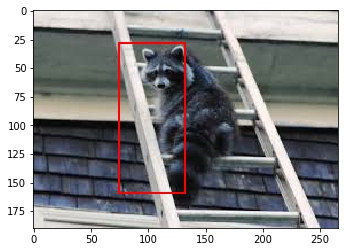

In [56]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

#### Change your present working directory

### Load your data file

#### Plot data

#### Descibe your dataframe

#### Check for null values

#### Drop null values

#### Get the representation of the distribution of data in the form of histogram

#### Check the maximum and minimum values

### Normalize the data

#### Check the maximum and minimum values of scaled data

#### Look into some of the scaled values

### Split data into Training and Testing

#### Print train and test size

## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

#### Use function to get training and test set

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

## Define Model

### Define sequntial model, add LSTM layer and compile the model

### Summarize your model

### Train the model

## Make Predictions and Evaluate your model

## Plot the results